In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vSbz4CAAr0-w7Rw7NRakWrj06YNF4sWlYBS_f0k-CK_DmseZq-SxB9d5K8XZsMhDci4I3dtXNt8iu9m/pub?output=csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


В датасете представлены данные 891 пассажира Титаника. Данные содержат:

- id пассажира (PassengerId)

- выжил ли пассажир (Survived) // Целевая переменная

- имя пассажира (Name)

- пол пассажира (Sex)

- возраст пассажира (Age)

- количество родственников пассажира на борту Титаника (SibSp)

- количество родителей/детей пассажира на борту Титаника (Parch)

- номер билета пассажира (Ticket)

- цена билета пассажира (Fare)

- номер каюты пассажира (Cabin)

- пункт посадки пассажира на Титаник (Embarked)

Таким образом, нам нужно построить модель, которая по имеющимся данным о пассажире могла бы предсказывать, выжил человек после крушения Титаника или нет.

# Предобработка данных

## 1. Удалим ненужные колонки.

Очевидно, что выживаемость на Титанике не зависела от имени пассажира, номера его билета и Id. Удалим эти колонки:

In [3]:
data = data.drop(['PassengerId', 'Name', 'Ticket'], axis=1)
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,NaN,S
3,1,1,female,35.0,1,0,53.1000,C123,S
4,0,3,male,35.0,0,0,8.0500,NaN,S


Отделим колонку целевой переменной от датасета и разделим датасет на тренировочную и тестовую выборку.

In [4]:
y = data['Survived']

X = data.drop('Survived', axis=1)

Посмотрим какие колонки получились в данных и какого типа данные в них записаны:

In [5]:
data.dtypes

Survived      int64
Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Cabin        object
Embarked     object
dtype: object

Проверим, в каких колонках есть пропуски:

In [6]:
data.columns[data.isna().any()].tolist()

['Age', 'Cabin', 'Embarked']

## Заполним пропуски

1. Age

Так как Age - числовой признак, заполним пропуски медианным значением возраста:

In [7]:
X['Age'] = X['Age'].fillna(X['Age'].median())

2. Embarked 

Embarked - категориальный признак, есть смысл заполнить пропуски наиболее частым значением признака, так как, вероятнее всего, элементы с пропусками имели именно это значение.

In [8]:
X['Embarked'].value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

In [9]:
X['Embarked'] = X['Embarked'].fillna('S')

3. Cabin

In [10]:
X['Cabin'].isna().sum(), len(X), round(X['Cabin'].isna().sum() / len(X), 2)

(687, 891, 0.77)

Как видно, в данной колонке пропуски составляют 77% от всех данных, следовательно, не получится их заменить без искажения данных. Удалим данную колонку:

In [11]:
X = X.drop('Cabin', axis=1)

Убедимся в отсутсвии пропусков в исправленном датасете:

In [12]:
X.isnull().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

## Перевод категориальных признаков в числовые

1. Sex

In [13]:
X['Sex'].describe()

count      891
unique       2
top       male
freq       577
Name: Sex, dtype: object

В данном столбце представлено 2 различных значения - male и female, заменим их на 1 и 0 соответственно.

In [14]:
X['Sex'] = X['Sex'].astype('category')
X['Sex'] = X['Sex'].cat.codes

2. Embarked

Данный стоблик содержит 3 разных значения, используем для его преобразования one-hot-encoder:

In [15]:
X = pd.get_dummies(X, columns=['Embarked'])
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
0,3,1,22.0,1,0,7.2500,False,False,True
1,1,0,38.0,1,0,71.2833,True,False,False
2,3,0,26.0,0,0,7.9250,False,False,True
3,1,0,35.0,1,0,53.1000,False,False,True
4,3,1,35.0,0,0,8.0500,False,False,True


## Сплит данных на train и test выборки

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Обучение модели

In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [18]:
knn = KNeighborsClassifier(n_neighbors=3)

knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [19]:
y_pred = knn.predict(X_test)

In [20]:
accuracy_score(y_pred, y_test)

0.7164179104477612

Прогноз нашей модели оказался на 71.7% верным.

## Подбор гиперпараметра k

Проверим все k от 1 до 20 включительно, обучим для каждого k модель и посчитаем accuracy_score, чтобы выбрать лучший гиперпараметр.

In [21]:
acc_scores = []

for k in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    acc_score = accuracy_score(y_pred, y_test)
    
    acc_scores.append(acc_score)

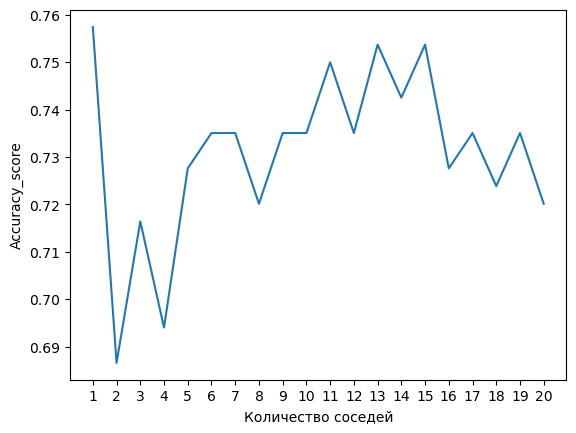

In [22]:
import matplotlib.pyplot as plt

plt.plot(list(range(1, 21)), acc_scores)
plt.xticks(list(range(1, 21)))
plt.xlabel('Количество соседей')
plt.ylabel('Accuracy_score')
plt.show()

На графике видно, что при $k=1$ accuracy_score принимает наивысшее значением, попробуем обучить нашу модель с гиперпараметров $k=1$

In [31]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
accuracy_score(y_pred, y_test)

0.7574626865671642

Как видно, качество модели выросло на 4%, что не слишком много, но тем не менее лучше предыдущей.

# Получение ответов для тестового датасета

In [24]:
test_data = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vSJ7pmMhHTnNo0dvCms4SanPbyGIAuVaGv1sBmSPbOquct5nLgzFqd4PM6qfH0zH9AhgasV6WNvLxi5/pub?output=csv')
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


Совершим те же преобразования, что и с тренировочными данными:

In [25]:
#  Удаляем колонки
test_data = test_data.drop(['PassengerId', 'Name', 'Ticket'], axis=1)

#  Заполняем пропуски
test_data['Age'] = test_data['Age'].fillna(28)
test_data['Embarked'] = test_data['Embarked'].fillna('S')
test_data = test_data.drop('Cabin', axis=1)

#  Переводим категориальные данные в числовые
test_data['Sex'] = test_data['Sex'].astype('category')
test_data['Sex'] = test_data['Sex'].cat.codes

test_data = pd.get_dummies(test_data, columns=['Embarked'])
test_data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
0,3,1,34.5,0,0,7.8292,False,True,False
1,3,0,47.0,1,0,7.0000,False,False,True
2,2,1,62.0,0,0,9.6875,False,True,False
3,3,1,27.0,0,0,8.6625,False,False,True
4,3,0,22.0,1,1,12.2875,False,False,True


Проверим наличие пропусков:

In [26]:
test_data.isna().any()

Pclass        False
Sex           False
Age           False
SibSp         False
Parch         False
Fare           True
Embarked_C    False
Embarked_Q    False
Embarked_S    False
dtype: bool

Заполним пропуски в колонке Fare медианой всех значений тренировочного датасета

In [27]:
test_data['Fare'] = test_data['Fare'].fillna(X['Fare'].median())

Обучим KNN на всей тренировочной выборке с оптимальным $k=1$, полученным ранее

In [32]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X, y)

KNeighborsClassifier(n_neighbors=1)

In [33]:
y_pred_test = knn.predict(test_data)

In [34]:
y_pred_test = pd.DataFrame({'Survived': y_pred_test})
y_pred_test['PassengerId'] = list(range(892, 892+len(test_data)))
y_pred_test

,Survived,PassengerId
0,0,892
1,0,893
2,1,894
3,1,895
4,0,896
...,...,...
413,0,1305
414,1,1306
415,0,1307
416,0,1308


Получаем готовый датасет с предсказанными значениями.